In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler


In [2]:
inputs_data = [
    {
        'name': 'BTC_USD',
        'data': pd.read_csv('BTC-USD.csv'),
    },
    {
        'name': 'ETH_USD',
        'data': pd.read_csv('ETH-USD.csv')
    },
    {
        'name': 'ADA_USD',
        'data': pd.read_csv('ADA-USD.csv')
    }
]

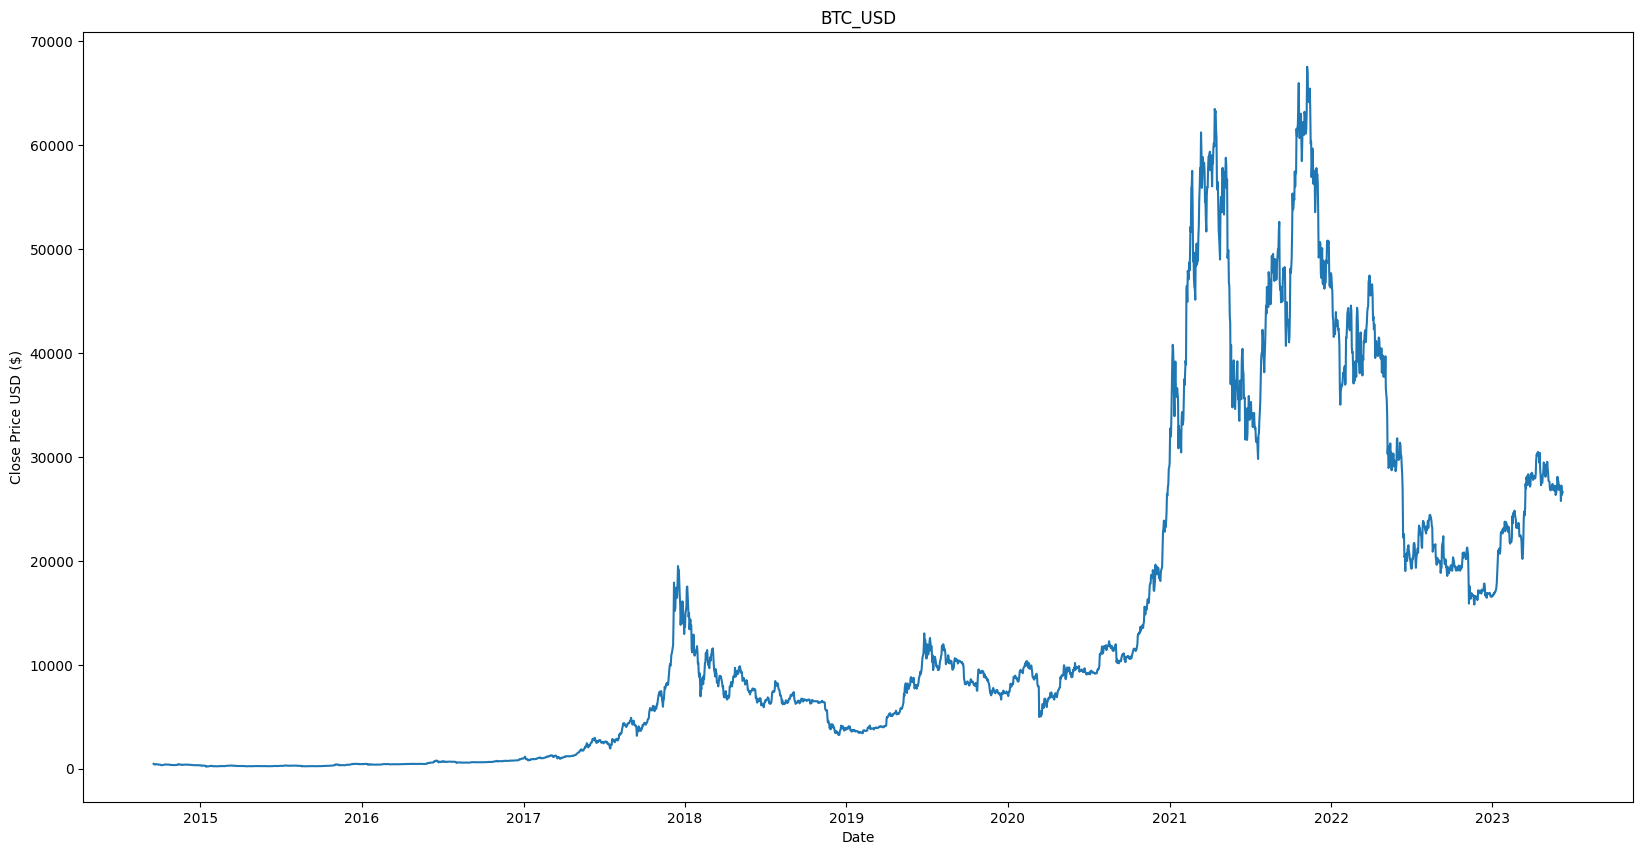

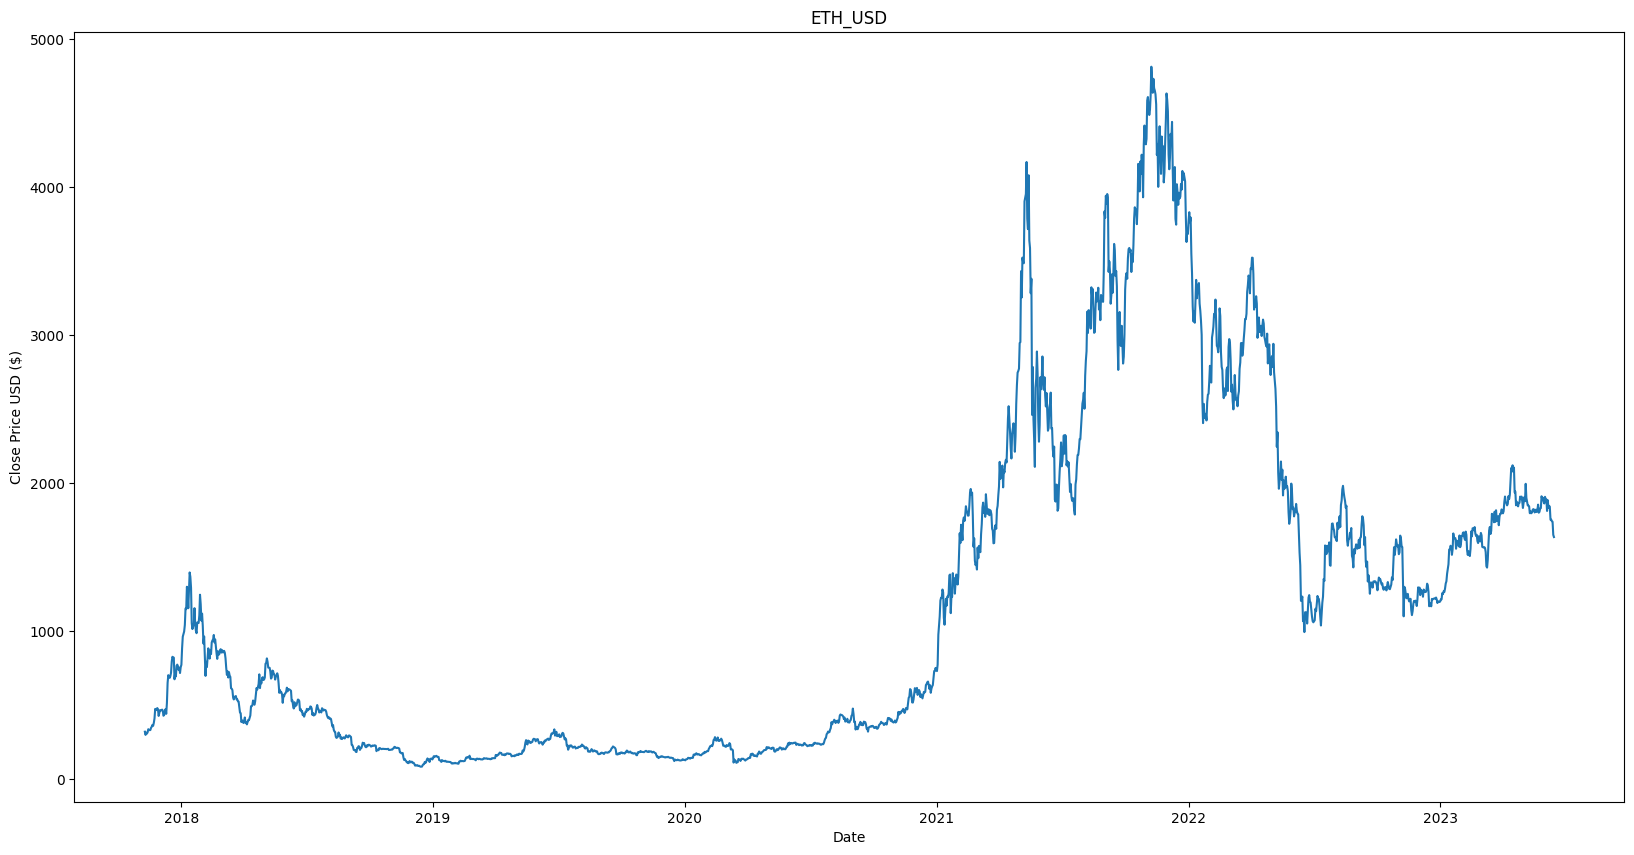

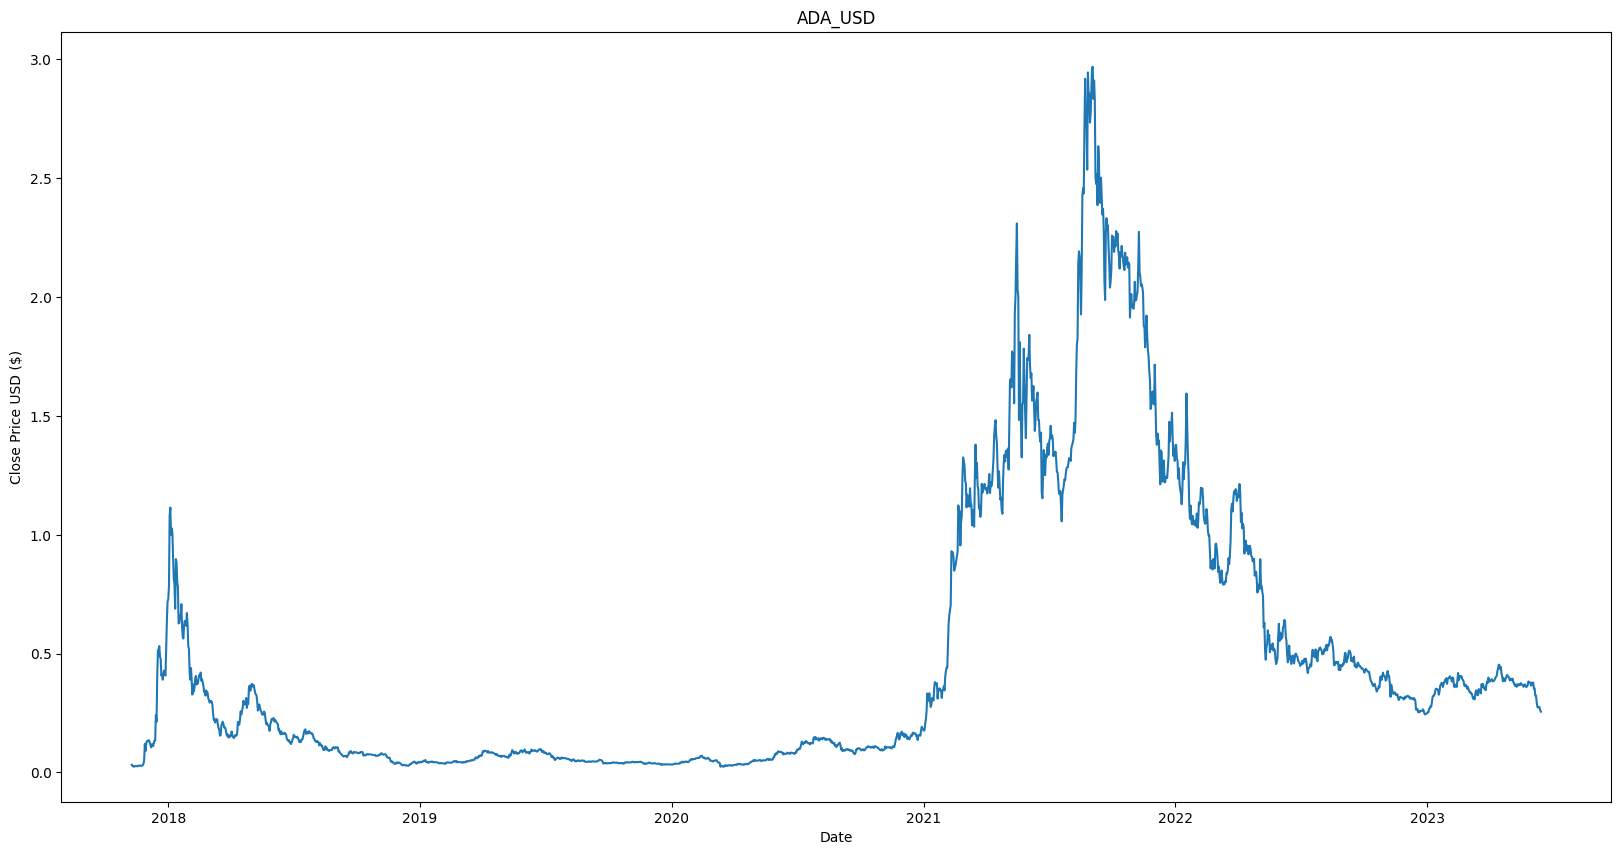

In [3]:
for item in inputs_data:
    item['data']["Date"]=pd.to_datetime(item['data'].Date,format="%Y-%m-%d")
    item['data'].index=item['data']['Date']

    plt.title(item['name'])
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(item['data']['Close'], label='Close Price history')
    plt.show()

In [4]:
number_of_days = 100
for item in inputs_data:
    data = item['data'].sort_index(ascending=True, axis=0)
    item['new_dataset'] = pd.DataFrame(index=range(0, len(item['data'])), columns=['Date', 'Close'])
    for i in range(0, len(data)):
        item['new_dataset']["Date"][i] = data['Date'][i]
        item['new_dataset']["Close"][i] = data["Close"][i]
    
    item['new_dataset'].index = item['new_dataset'].Date
    item['new_dataset'].drop("Date", axis=1, inplace=True)

    item['dataset'] = item['new_dataset'].values
    breakpoint = int(len(item['dataset']) * 0.7)
    item['train'] = item['dataset'][0:breakpoint, :]
    item['valid'] = item['dataset'][breakpoint:, :]

    item['scaler'] = MinMaxScaler(feature_range=(0, 1))
    item['scaled_data'] = item['scaler'].fit_transform(item['dataset'])

    item['x_train'], item['y_train'] = [], []

    for i in range(number_of_days, len(item['train'])):
        item['x_train'].append(item['scaled_data'][i - number_of_days:i, 0])
        item['y_train'].append(item['scaled_data'][i, 0])
    
    item['x_train'], item['y_train'] = np.array(item['x_train']), np.array(item['y_train'])
    item['x_train'] = np.reshape(item['x_train'], (item['x_train'].shape[0], item['x_train'].shape[1], 1))


In [5]:
for item in inputs_data:
    lstm_model=Sequential()
    lstm_model.add(LSTM(units=150,return_sequences=True,input_shape=(item['x_train'].shape[1],1)))
    lstm_model.add(LSTM(units=150))
    lstm_model.add(Dense(1))

    item['inputs_data'] = item['new_dataset'][len(item['new_dataset']) - len(item['valid']) - number_of_days:].values
    item['inputs_data'] = item['inputs_data'].reshape(-1, 1)
    item['inputs_data'] = item['scaler'].transform(item['inputs_data'])

    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(item['x_train'],item['y_train'],epochs=1,batch_size=1,verbose=2)

    item['lstm_model'] = lstm_model

2131/2131 - 121s - loss: 1.7279e-04 - 121s/epoch - 57ms/step
1331/1331 - 73s - loss: 0.0015 - 73s/epoch - 55ms/step
1331/1331 - 72s - loss: 0.0026 - 72s/epoch - 54ms/step


In [6]:
for item in inputs_data:
    X_test=[]
    for i in range(number_of_days,item['inputs_data'].shape[0]):
        X_test.append(item['inputs_data'][i-number_of_days:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    item['predicted_closing_price'] = item['lstm_model'].predict(X_test)
    item['predicted_closing_price'] = item['scaler'].inverse_transform(lstm_model.predict(X_test))

    

20/20 [==============================] - 2s 103ms/step


In [7]:
for item in inputs_data:
    item['lstm_model'].save(item['name'] + "_model.h5")


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1876\2652004370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['valid_data']['Predictions'] = item['predicted_closing_price']


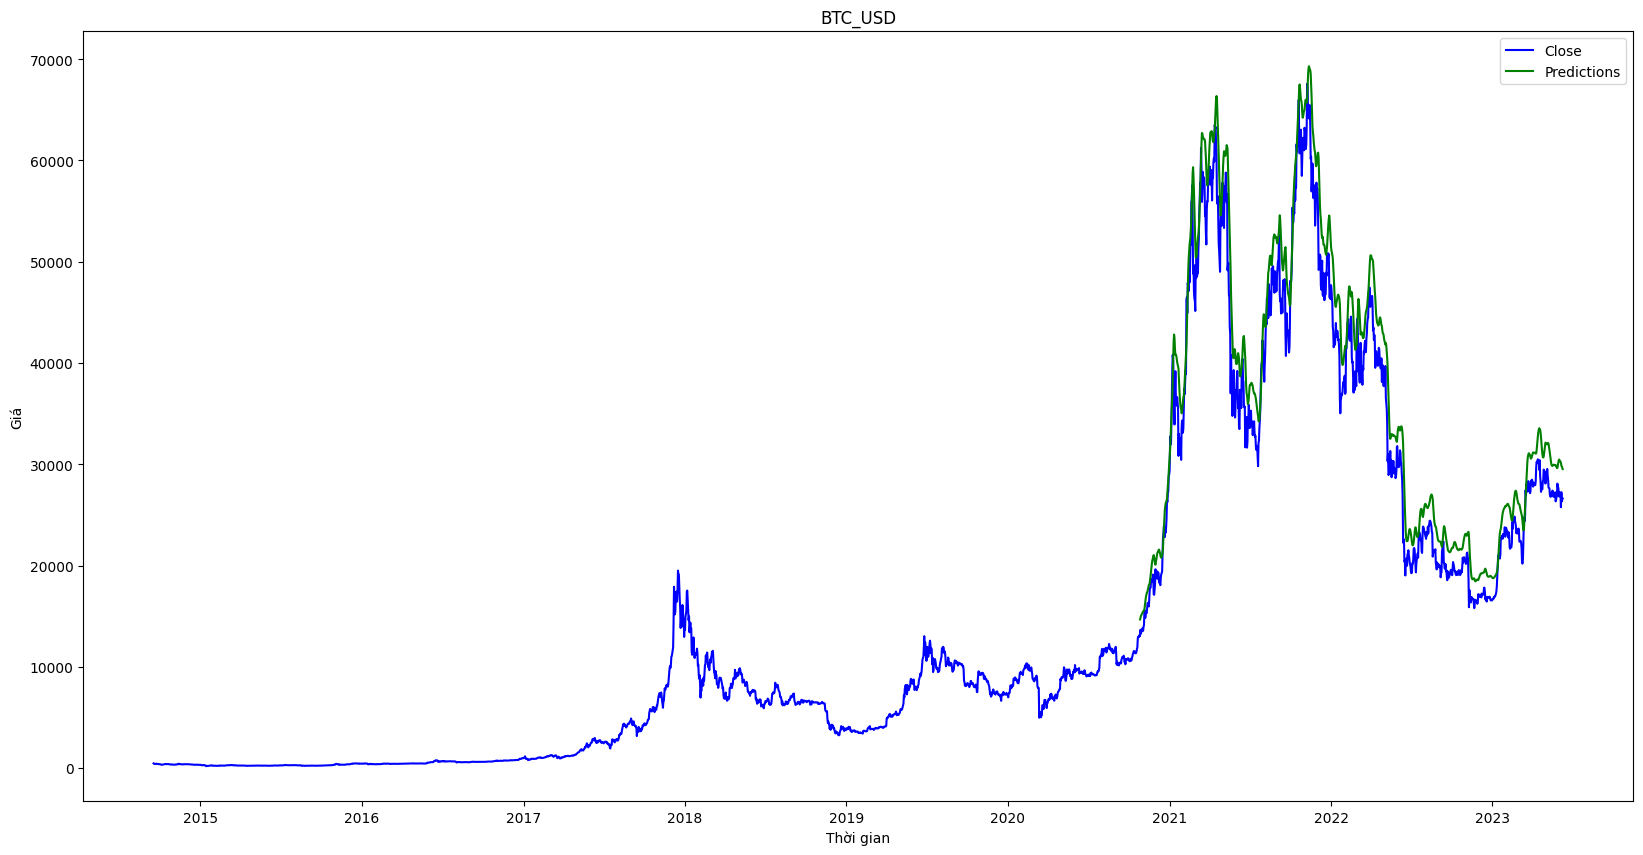

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1876\2652004370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['valid_data']['Predictions'] = item['predicted_closing_price']


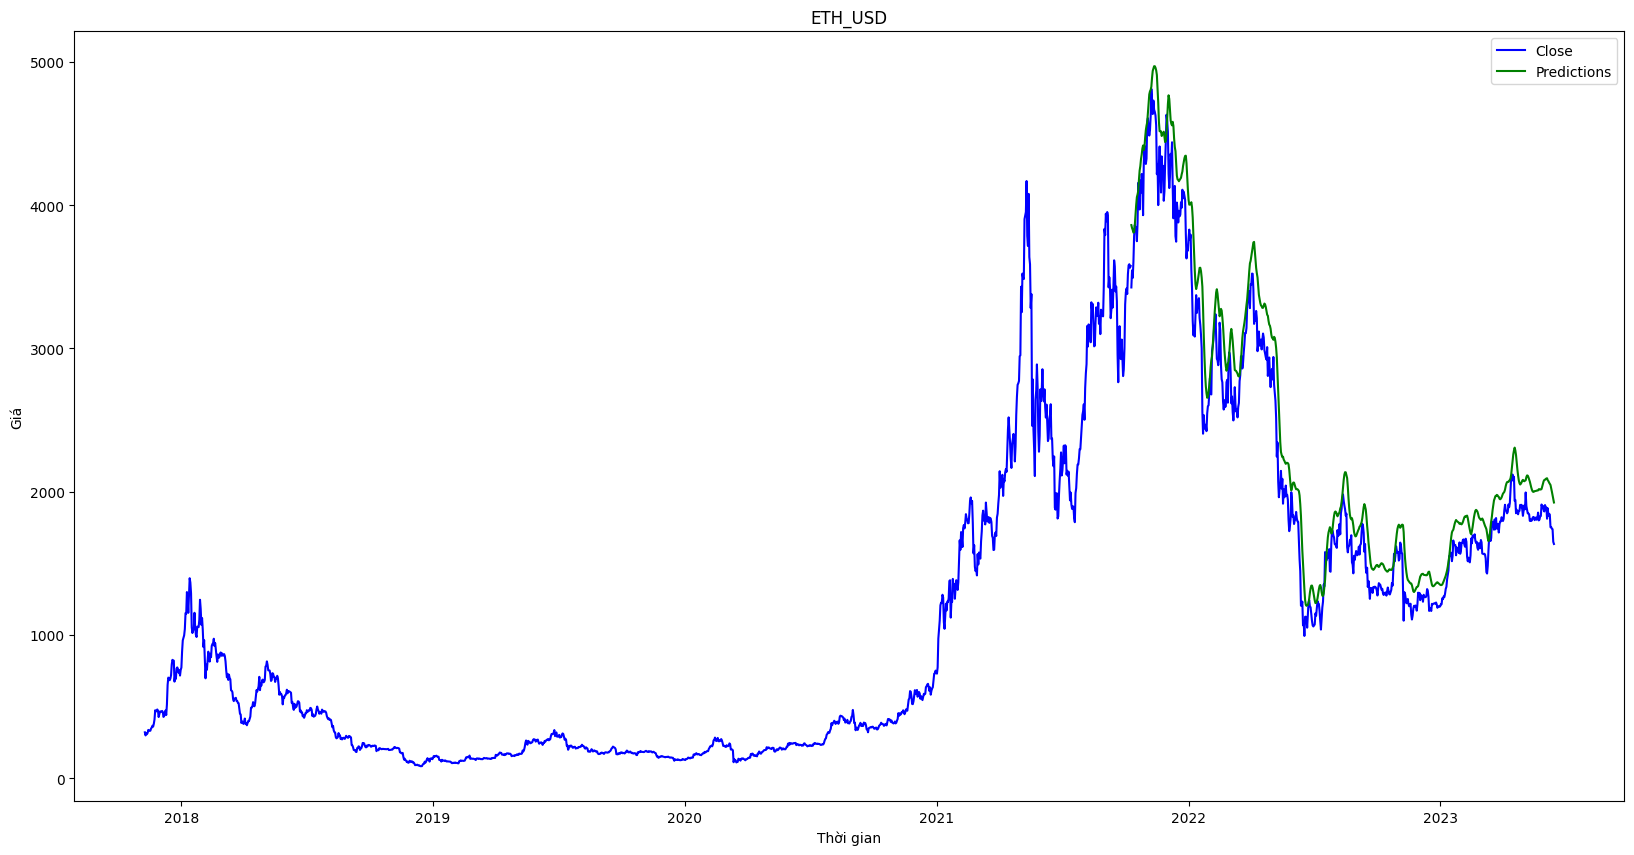

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1876\2652004370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['valid_data']['Predictions'] = item['predicted_closing_price']


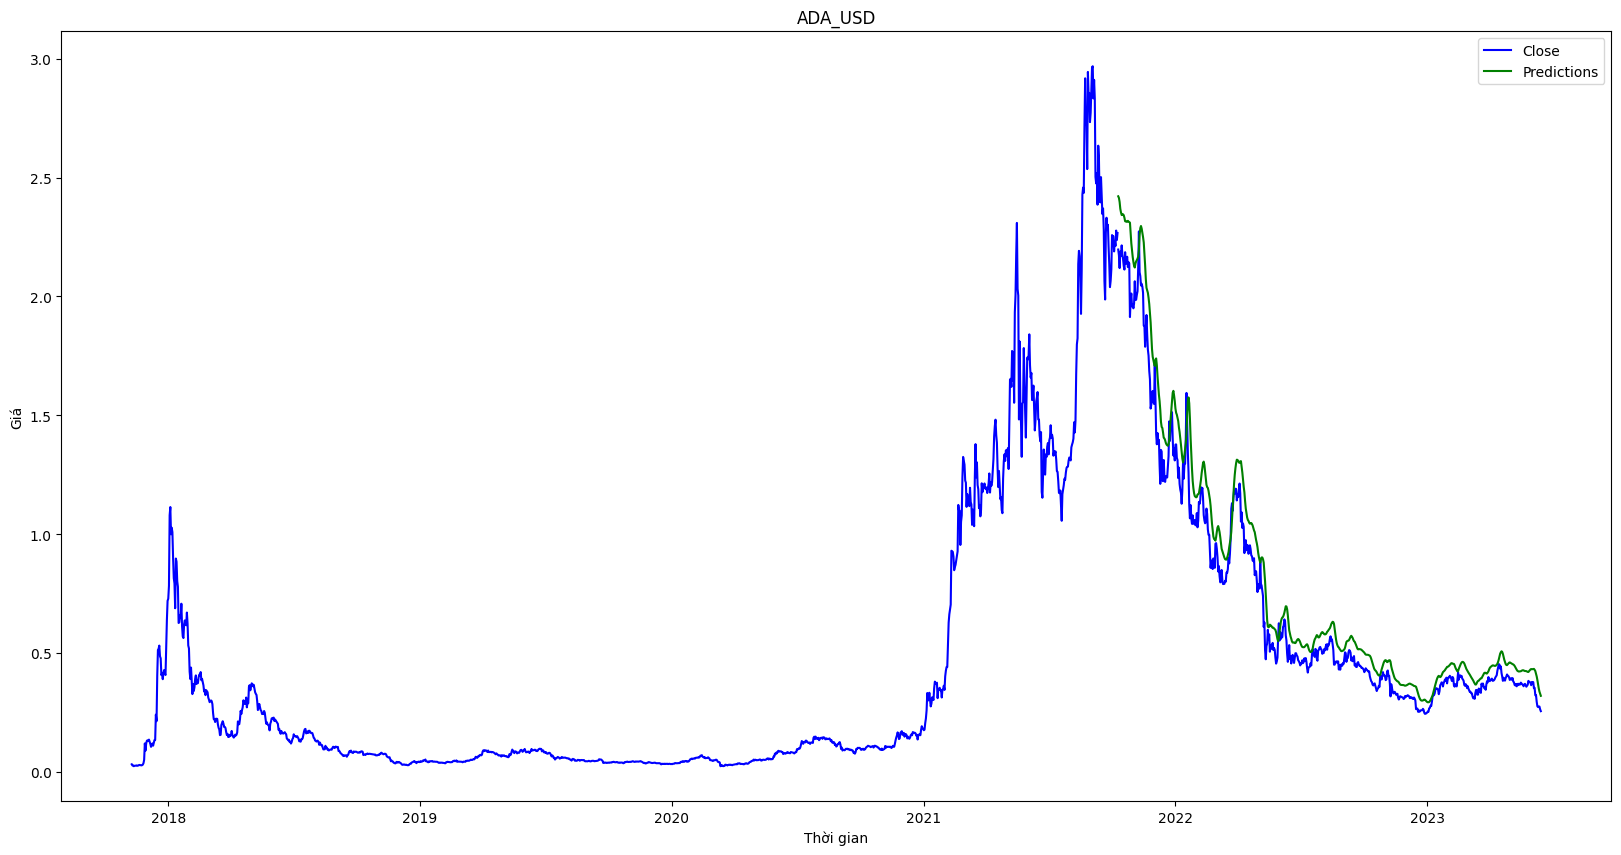

In [8]:
for item in inputs_data:
    breakpoint = int(len(item['new_dataset']) * 0.7)
    item['train_data'] = item['new_dataset'][:breakpoint]
    item['valid_data'] = item['new_dataset'][breakpoint:]
    item['valid_data']['Predictions'] = item['predicted_closing_price']
    plt.plot(item['train_data']["Close"],color='blue')
    plt.plot(item['valid_data']['Close'], color='blue', label='Close')
    plt.plot(item['valid_data']['Predictions'], color='green', label='Predictions')

    # Các thiết lập khác (tiêu đề, trục, chú thích)...
    plt.title(item['name'])
    plt.xlabel('Thời gian')
    plt.ylabel('Giá')
    plt.legend()

    plt.show()